© 2024 Luca Kunz. Commercial use is subject to the terms of the source repository's license. All other commercial rights are reserved.

# Infer the polarity of the vorticity field around a TRAP

Load the TRAPS .pkl file of a given year, extract the coordinate columns and draw a circle around every TRAP core.  
We call this circle a vorticity circle or `vircle` where $\alpha$ describes the angle of circle parameterisation.  
Simultaneously, we load the respective vorticity field and interpolate the daily surrounding vorticity field to each point of the vorticity circle.  
This gives us the vorticity along the circle which we simply call vorticity curve $\zeta(\alpha)$ or `vurve`. 

The vorticity curve will reveal vortex polarity changes in the environment of a TRAP core and we can use it to find quadrupoles and other polarity patterns in the surroundings.  
Therefore, we divide the vorticity circle into 4 intervals of $\Delta\alpha=\pi/2$ and use them to filter the vorticity curve $\zeta(\alpha)$ for combinations of four vortices.  

We don't loop through years to be able to spread yearly runs across multiple threads as the interpolation takes some cpu time. The results will be exported as yearly .pkl files again which constitute the final TRAPs dataset for publication.

In [1]:
import os
import sys
import numpy as np
from scipy.interpolate import interp2d
import pandas as pd
import time
import datetime
import pickle

from IPython.display import display, Audio
# import jupyter notebook files like regular python modules
import import_ipynb
from aa_define_classes import TRAPSdata

importing Jupyter notebook from aa_define_classes.ipynb


In [2]:
# measure the computation time for the entire script
start_script_timer = time.perf_counter()

# Preliminary

## Pickle object saving function

In [3]:
def save_object(obj, filename):
    with open(filename, 'wb') as outp:  # overwrites any existing file.
        pickle.dump(obj, outp, pickle.HIGHEST_PROTOCOL)

## Files and paths

In [4]:
# if script is running in jupyter lab
if sys.argv[0].endswith("ipykernel_launcher.py"):
    # set the velocity product
    vel_product_ID = 1
    epsilon_ID = 1
    year_index = 0
    notebook_run = True
    # save_fig = True
    save_fig = False


# if script is running as python script
else:
    # read in product from bash
    vel_product_ID = int(sys.argv[1])
    # read in epsilon from bash
    epsilon_ID = int(sys.argv[2])
    # read in year from bash
    year_index = int(sys.argv[3])
    notebook_run = False
    save_fig = True


vel_product_short = ['ENSRYS_24HM', 'MULTIOBS_24HI', 'MULTIOBS_24HM', 'SEALEVEL_24HI'][vel_product_ID]

vel_product_long = ['CMEMS GLOBAL_REANALYSIS_PHY_001_031 ENSEMBLE MEAN (1/4°, 24HM)', 
                    'CMEMS MULTIOBS_GLO_PHY_REP_015_004 (1/4°, 24HI)', 
                    'CMEMS MULTIOBS_GLO_PHY_REP_015_004 (1/4°, 24HM)', 
                    'CMEMS SEALEVEL_GLO_PHY_L4_MY_008_047 (1/4°, 24HI)'][vel_product_ID]


years = ['2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', 
         '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019']

year = years[year_index]

epsilon_value = [0.1, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0][epsilon_ID]
epsilon_string = ['_e010', '_e025', '_e050', '_e075', '_e100', '_e125', '_e150', '_e175', '_e200'][epsilon_ID]

In [5]:
# define the path to the pkl files
pkl_importpath = 'export_pkl/' + vel_product_short + '/20XX/'
pkl_exportpath = 'export_pkl/' + vel_product_short + '/20XX/'

## Define BCKGRND field domain boundaries

In [6]:
# the bounds set during the netCDF velocity field download
wbound_AVD = -160
ebound_AVD = -125
sbound_AVD = 22.5
nbound_AVD = 42.5

# the boundaries of the coincidence velocity grid
wbound_CVD = wbound_AVD + 0.125
ebound_CVD = ebound_AVD - 0.125
sbound_CVD = sbound_AVD + 0.125
nbound_CVD = nbound_AVD - 0.125

# Import TRAPS DataFrame

Load the TRAPS dataframe for the given year.

In [7]:
start_timer = time.perf_counter()

In [8]:
# define the pkl files to load
pkl_TRAPS_importname = vel_product_short + epsilon_string + '_TRAPS_SPEEDS_' + year + '.pkl'

# load the pickle object for the current year
with open(pkl_importpath + pkl_TRAPS_importname, 'rb') as inp:
    
    # load the complete dataframe
    pd_TRAPS_df = pickle.load(inp).pd_TRAPS_df.copy()

    
# reset the index after loading
pd_TRAPS_df.reset_index(drop=True, inplace=True)

In [9]:
# drop this column since it won't be used anymore
del pd_TRAPS_df['ED_TRAP']

In [10]:
# get the number of TRAP instances
number_of_TRAPS = pd_TRAPS_df.index.size

In [11]:
stop_timer = time.perf_counter()
print('loaded ' + pkl_TRAPS_importname + f' in: {stop_timer - start_timer:0.4f} seconds')

loaded MULTIOBS_24HI_e025_TRAPS_SPEEDS_2000.pkl in: 2.3715 seconds


# Import BCKGRND DataFrame

Load the dataframe that contains the vorticity field for the given year.  
We call this background field here, however, this term has nothing to do with the background vorticity that we subtract later for the NBV flag.

In [12]:
start_timer = time.perf_counter()

In [13]:
# define the pkl files to load
pkl_BCKGRND_importname = vel_product_short + '_FIELDS_VOR_' + year + '.pkl'

# load the pickle object for the current year
with open(pkl_importpath + pkl_BCKGRND_importname, 'rb') as inp:

    pd_BCKGRND_df = pickle.load(inp).pd_TRAPS_df.copy()
    
# reset the index after loading
pd_BCKGRND_df.reset_index(drop=True, inplace=True)

In [14]:
stop_timer = time.perf_counter()
print('loaded ' + pkl_BCKGRND_importname + f' in: {stop_timer - start_timer:0.4f} seconds')

loaded MULTIOBS_24HI_FIELDS_VOR_2000.pkl in: 0.2010 seconds


In [15]:
# print check
pd_TRAPS_df
#pd_BCKGRND_df

,TRAP_ID,time,core_lon,core_lat,core_attraction,curve_lons,curve_lats,curve_attractions,origin_ID,lifetime,age,track_s1_peak,core_U,core_V
0,0,2000-01-01,-159.045688,23.400981,-0.625117,"[-159.465202832297, -159.40044405039814, -159....","[23.1889083623293, 23.241294361583048, 23.2868...","[-0.31061579015898855, -0.4048254423681092, -0...",200001010000 000,16,1,-0.650914,NaN,NaN
1,1,2000-01-01,-159.503564,24.127516,-0.298961,"[-159.159668021201, -159.23795868926015, -159....","[23.8158077645795, 23.84382718973737, 23.89130...","[-0.30928585683127613, -0.24813203636879133, -...",200001010000 001,1,1,-0.298961,NaN,NaN
2,2,2000-01-01,-157.098753,23.351263,-0.484728,"[-156.959155383537, -156.97300069417307, -156....","[22.9518861202522, 23.033962489599663, 23.1132...","[-0.15850601318965057, -0.27230734428256403, -...",200001010000 002,20,1,-0.592701,NaN,NaN
3,3,2000-01-01,-157.279485,25.245133,-0.357612,"[-157.737693931696, -157.672992477558, -157.59...","[25.0607392199964, 25.11306391107641, 25.15033...","[-0.10810833887211632, -0.11965485823088562, -...",200001010000 003,17,1,-0.391277,NaN,NaN
4,4,2000-01-01,-157.825133,24.521705,-0.270798,"[-158.294683608633, -158.21303988239845, -158....","[24.521180619821, 24.504563408481385, 24.49381...","[-0.17313183251995282, -0.1924738129886017, -0...",200001010000 004,26,1,-0.359810,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210539,602,2000-12-31,-141.635983,39.745526,-0.172387,"[-141.985759360558, -141.9041207915777, -141.8...","[39.6437173355492, 39.634473490992114, 39.6572...","[-0.05775057250764737, -0.08731206210437456, -...",200012300000 609,3,2,-0.215968,-0.000071,-0.053034
210540,603,2000-12-31,-141.498361,33.983257,-0.253132,"[-141.58688784844, -141.54724872181143, -141.5...","[33.6745512798819, 33.747682851431435, 33.8267...","[-0.08191124836878169, -0.14418111289306007, -...",200012280000 227,36,4,-0.376136,-0.007830,0.008939
210541,604,2000-12-31,-142.074919,28.771750,-0.184957,"[-141.668381906843, -141.72614862092027, -141....","[28.5406194513576, 28.6006153253202, 28.652420...","[-0.11828477160716377, -0.11935055547709628, -...",200012260000 125,8,6,-0.184957,-0.037879,-0.044597
210542,605,2000-12-31,-141.846596,39.002991,-0.277369,"[-142.288278546339, -142.20522979965793, -142....","[38.9324068245497, 38.92851369811983, 38.94290...","[-0.08500366955216251, -0.11002349029517104, -...",200011190000 079,52,43,-0.564188,-0.034250,-0.007398


# Columns to arrays

Load the data needed for the vircle computation into numpy arrays.

In [16]:
core_lons = pd_TRAPS_df.core_lon.to_numpy(copy=True)
core_lats = pd_TRAPS_df.core_lat.to_numpy(copy=True)
curve_lons = pd_TRAPS_df.curve_lons.to_numpy(copy=True)
curve_lats = pd_TRAPS_df.curve_lats.to_numpy(copy=True)

# Flag suitable TRAPS

The dataframe contains TRAPS with only one curvepoint ($\rightarrow$ curve core distance = 0) or TRAPS too close to the CVD boundaries in order to draw vircles.  
These cases should be flagged and intercepted later when looping through the vircle parameterisation.

In [17]:
# FALSE flag all TRAPS which only consist of one curvepoint, 
# i.e. the core, and thus won't show a curve core distance which is useless in the following
multiple_curvepoints_filter = np.array([ccurve_lons.size>1 for ccurve_lons in curve_lons])

# also FALSE flag all TRAPS for which the core is closer than 0.5° to an CVD boundary
# since then vircles would lap out beyond the CVD boundaries
# actually even flag cores closer than 1° to the CVD boundaries to ensure 
# that we have at least one 1/4° vorticity field grid point beyond the vircle,
# i.e. between vircle and CVD boundary to get the interpolation from
# the background field boundaries actually aligns with some of the CVD boundaries
cvd_filter = (((core_lons - 1)>=wbound_CVD) & ((core_lons + 1)<=ebound_CVD) & 
              ((core_lats - 1)>=sbound_CVD) & ((core_lats + 1)<=nbound_CVD))

# flag all TRAPS which are suitable for the vircle parameterisation
vircles = multiple_curvepoints_filter & cvd_filter
novircles = ~vircles

In [18]:
# assign the flags to the dataframe
pd_TRAPS_df['vircle'] = vircles

In [19]:
# print check
print(str(sum(~multiple_curvepoints_filter)) + ' curves with only one curvepoint')
print(str(sum(~cvd_filter)) + ' cores too close to a CVD boundary')
print(str(sum(novircles)) + ' TRAPS without vircle parameterisation')
print()

0 curves with only one curvepoint
26261 cores too close to a CVD boundary
26261 TRAPS without vircle parameterisation



# Find furthest curvepoint

For every TRAP, calculate the distance between core and all curve points and find the curve point which is furthest from the core.  
The distance between this curve point and the core determines the radius of the VIRCLE and the phase shift of the starting point of the VURVE.

In [20]:
curve_core_distance_lons = curve_lons - core_lons
curve_core_distance_lats = curve_lats - core_lats

curve_core_distances = (curve_core_distance_lons**2 + curve_core_distance_lats**2)**0.5

In [21]:
# find the index of the curvepoint furthest from the core, we also need this for getting the phase shift
furthest_curvepoint_indices = np.array([np.argmax(ccurve_core_distances) 
                                       for ccurve_core_distances in curve_core_distances])

In [22]:
# print check
curve_core_distance_lons
curve_core_distance_lats
curve_core_distances
furthest_curvepoint_indices

array([0, 0, 0, ..., 0, 0, 9])

# Draw vircles

We draw a circle around every TRAP core with the distance between core and furthest curve point as radius. Actually we want to start the drawing at the position of the furthest curve point and then move counter-clockwise such that we can directly relate vorticity signs and their position along the TRAP curve. But as the TRAP curve can be oriented arbitrarily in space and we want to bypass a coordinate transformation, we take an alternative approach.  

- determine the vector pointing from core to the furthest curve point
- get its angle to the zonal axis 0° pointing Eastwards and angle increasing counter-clockwise, this is the phase shift
- define raw angles alpha for the circle parameteristaion where alpha=0° points Eastwards and alpha increases counter-clockwise
- shift all alpha values by the phase shift by simply adding it $\rightarrow$ the vircle/vurve will start at the furthest curve point
- parameterise the vircle with these new angles `beta` = `alpha` + `phase_shift`
- (later) interpolate the vorticity field to the points on the vircle

Note that `beta` and `alpha` in this script are angles with the zonal axis 0° pointing Eastward. $\alpha$, however, refers to the rotated system and $\alpha=0$° coincides with the vector pointing from the TRAP core to the furthest point on the TRAP curve. In later scripts where we analyse vorticity curves, we will represent  $\alpha$ with a variable called `alpha` which has nothing to do with the same-named variable in this script. It's confusing.

When drawing vircles around TRAPs, we skip TRAPS which only consist of one curve point or are too close to the domain boundaries to interpolate the vorticity field to it.

## Get radius

In [23]:
# find the components of the vector to the furthest curvepoint, i.e. where vurve should start
vircle_startvector_lons = np.array([curve_core_distance_lons[ix][furthest_curvepoint_indices[ix]] 
                                   for ix in range(number_of_TRAPS)])
vircle_startvector_lats = np.array([curve_core_distance_lats[ix][furthest_curvepoint_indices[ix]] 
                                   for ix in range(number_of_TRAPS)])

# find the distance of the furthest curvepoint, i.e. the radius of the vircle
vircle_radii = np.array([curve_core_distances[ix][furthest_curvepoint_indices[ix]] for ix in range(number_of_TRAPS)])

# the furthest distance should be the length of the startvector
assert np.all(vircle_radii==(vircle_startvector_lons**2 + vircle_startvector_lats**2)**0.5), 'found deprecated vircle radius'

# there should be no vircle radius of negative length
assert np.all(vircle_radii>=0), 'found negative vircle radius'
# THE BELOW IS NOT CORRECT since there can be truncated curves for which core and 1 curvepoint do not exactly match
# and the number of zero length radii should be equal to the number of TRAPS with one curvepoint
#assert sum(vircle_radii==0)==sum(~multiple_curvepoints_filter), 'more/less zero length radii than one curvepoint TRAPS'

In [24]:
# print check
#vircle_startvectors_lon
#vircle_startvectors_lat
vircle_radii
pd_TRAPS_df

,TRAP_ID,time,core_lon,core_lat,core_attraction,curve_lons,curve_lats,curve_attractions,origin_ID,lifetime,age,track_s1_peak,core_U,core_V,vircle
0,0,2000-01-01,-159.045688,23.400981,-0.625117,"[-159.465202832297, -159.40044405039814, -159....","[23.1889083623293, 23.241294361583048, 23.2868...","[-0.31061579015898855, -0.4048254423681092, -0...",200001010000 000,16,1,-0.650914,NaN,NaN,False
1,1,2000-01-01,-159.503564,24.127516,-0.298961,"[-159.159668021201, -159.23795868926015, -159....","[23.8158077645795, 23.84382718973737, 23.89130...","[-0.30928585683127613, -0.24813203636879133, -...",200001010000 001,1,1,-0.298961,NaN,NaN,False
2,2,2000-01-01,-157.098753,23.351263,-0.484728,"[-156.959155383537, -156.97300069417307, -156....","[22.9518861202522, 23.033962489599663, 23.1132...","[-0.15850601318965057, -0.27230734428256403, -...",200001010000 002,20,1,-0.592701,NaN,NaN,False
3,3,2000-01-01,-157.279485,25.245133,-0.357612,"[-157.737693931696, -157.672992477558, -157.59...","[25.0607392199964, 25.11306391107641, 25.15033...","[-0.10810833887211632, -0.11965485823088562, -...",200001010000 003,17,1,-0.391277,NaN,NaN,True
4,4,2000-01-01,-157.825133,24.521705,-0.270798,"[-158.294683608633, -158.21303988239845, -158....","[24.521180619821, 24.504563408481385, 24.49381...","[-0.17313183251995282, -0.1924738129886017, -0...",200001010000 004,26,1,-0.359810,NaN,NaN,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210539,602,2000-12-31,-141.635983,39.745526,-0.172387,"[-141.985759360558, -141.9041207915777, -141.8...","[39.6437173355492, 39.634473490992114, 39.6572...","[-0.05775057250764737, -0.08731206210437456, -...",200012300000 609,3,2,-0.215968,-0.000071,-0.053034,True
210540,603,2000-12-31,-141.498361,33.983257,-0.253132,"[-141.58688784844, -141.54724872181143, -141.5...","[33.6745512798819, 33.747682851431435, 33.8267...","[-0.08191124836878169, -0.14418111289306007, -...",200012280000 227,36,4,-0.376136,-0.007830,0.008939,True
210541,604,2000-12-31,-142.074919,28.771750,-0.184957,"[-141.668381906843, -141.72614862092027, -141....","[28.5406194513576, 28.6006153253202, 28.652420...","[-0.11828477160716377, -0.11935055547709628, -...",200012260000 125,8,6,-0.184957,-0.037879,-0.044597,True
210542,605,2000-12-31,-141.846596,39.002991,-0.277369,"[-142.288278546339, -142.20522979965793, -142....","[38.9324068245497, 38.92851369811983, 38.94290...","[-0.08500366955216251, -0.11002349029517104, -...",200011190000 079,52,43,-0.564188,-0.034250,-0.007398,True


## Get phase shifts

In [25]:
# get the angle between the startpoint vector and the zonal axis, i.e. the phase shift of the vurve
# with 0° pointing Eastward and angle increasing counter-clockwise
# we will need this to later shift the raw vurve to where the vircle actually starts
# this way we can directly inspect the polarity cases we are looking for 
# by looking at the signs of the four quadrants of the shifted vurve

# in radians
phase_shifts = []

for ix in range(number_of_TRAPS):
    
    # run this for all TRAPs!
    # # skip TRAPS without vircles
    # if novircles[ix]: 
    #     phase_shifts.append(np.nan)
    #     continue
        
    # c for current
    cvector_lon = vircle_startvector_lons[ix]
    cvector_lat = vircle_startvector_lats[ix]

    if ((cvector_lon > 0) & (cvector_lat >= 0)): # [0°,90°)

        cphase_shift = abs(np.arctan(cvector_lat/cvector_lon))

    elif ((cvector_lon <= 0) & (cvector_lat > 0)): # [90°,180°)

        cphase_shift = np.pi/2 + abs(np.arctan(cvector_lon/cvector_lat))

    elif ((cvector_lon < 0) & (cvector_lat <= 0)): # [180°,270°)

        cphase_shift = np.pi + abs(np.arctan(cvector_lat/cvector_lon))

    elif ((cvector_lon >= 0) & (cvector_lat < 0)): # [270°,360°)

        cphase_shift = np.pi*3/2 + abs(np.arctan(cvector_lon/cvector_lat))
        
    else:

        # raise ValueError('found suitable TRAP with zero vircle radius')
        cphase_shift = np.nan

    phase_shifts.append(cphase_shift)
    
    
phase_shifts = np.array(phase_shifts)

In [26]:
# assign to dataframe since it will be needed for composit plots later
pd_TRAPS_df['phase_shift'] = phase_shifts

In [27]:
# print check
# pd_TRAPS_df

## Vircle parameterisation

As we know every vircle radius and phase shift, we can create circles which start on the zonal axis with 0° pointing Eastwards, angle increasing counter-clockwise and shift their start point to the location of the furthest curvepoint. In the next section we then interpolate the vorticity field to the points on this circle.

Note that `beta` and `alpha` in this script are angles with the zonal axis 0° pointing Eastward. $\alpha$, however, refers to the rotated system and $\alpha=0$° coincides with the vector pointing from the TRAP core to the furthest point on the TRAP curve. In later scripts where we analyse vorticity curves, we will represent  $\alpha$ with a variable called `alpha` which has nothing to do with the same-named variable in this script. It's confusing.

When iterating, skip all TRAPS which are not suited for the vircle parameterisation.

In [28]:
# define all raw angles for which to define a vircle point, currently with a spacing of 5°
alphas = np.arange(0, 2*np.pi, 5*2*np.pi/360) # in radians

# assert that the number of vircle points is divisible by 4
# such that later we can divide the vircle into four elements
assert alphas.size % 4 == 0, 'number of vircle points not divisible by 4'

In [29]:
# initiate the lists to save the readily shifted vircle points
vircle_lons = []
vircle_lats = []

for ix in range(number_of_TRAPS):

    # skip TRAPS without vircles
    if novircles[ix]: 
        vircle_lons.append(np.array([]))
        vircle_lats.append(np.array([]))
        continue    
    
    current_radius = vircle_radii[ix]

    # get the array of angels shifted by the phase shift of the current TRAP/vircle
    current_betas = alphas + phase_shifts[ix]
    
    # for each TRAP get the vectors to the points on the vircle with the TRAP core at the center, 
    # so these are relative coordinates
    current_vircle_vector_lons = current_radius * np.cos(current_betas)
    current_vircle_vector_lats = current_radius * np.sin(current_betas)

    # get the actual coordinates of the points on the current vircle
    current_vircle_lons = current_vircle_vector_lons + core_lons[ix]
    current_vircle_lats = current_vircle_vector_lats + core_lats[ix]
    
    # append to the overall column list
    vircle_lons.append(current_vircle_lons)
    vircle_lats.append(current_vircle_lats)
    
    

In [30]:
# assign to dataframe
pd_TRAPS_df['vircle_lons'] = vircle_lons
pd_TRAPS_df['vircle_lats'] = vircle_lats

# get the array from the dataframe inorder to have arrays in arrays and no 2D array
# which one would get with np.array(), this overwrites the lists
vircle_lons = pd_TRAPS_df.vircle_lons.to_numpy(copy=True)
vircle_lats = pd_TRAPS_df.vircle_lats.to_numpy(copy=True)

In [31]:
# assert that for all suitable TRAPS we have as many vircle coordinates as we have defined angles
assert np.all([vircle_array.size==alphas.size for vircle_array in vircle_lons[vircles]]), 'vircle coordinate array with wrong # coordinates for suitable TRAP'
assert np.all([vircle_array.size==alphas.size for vircle_array in vircle_lats[vircles]]), 'vircle coordinate array with wrong # coordinates for suitable TRAP'
# assert that for all unsuitable TRAPS we have no vircle coordinates
assert np.all([vircle_array.size==0 for vircle_array in vircle_lons[novircles]]), 'vircle coordinate array with wrong # coordinates for unsuitable TRAP'
assert np.all([vircle_array.size==0 for vircle_array in vircle_lats[novircles]]), 'vircle coordinate array with wrong # coordinates for unsuitable TRAP'

In [32]:
# print check
current_betas
vircle_lons
vircle_lats
pd_TRAPS_df

,TRAP_ID,time,core_lon,core_lat,core_attraction,curve_lons,curve_lats,curve_attractions,origin_ID,lifetime,age,track_s1_peak,core_U,core_V,vircle,phase_shift,vircle_lons,vircle_lats
0,0,2000-01-01,-159.045688,23.400981,-0.625117,"[-159.465202832297, -159.40044405039814, -159....","[23.1889083623293, 23.241294361583048, 23.2868...","[-0.31061579015898855, -0.4048254423681092, -0...",200001010000 000,16,1,-0.650914,NaN,NaN,False,3.609645,[],[]
1,1,2000-01-01,-159.503564,24.127516,-0.298961,"[-159.159668021201, -159.23795868926015, -159....","[23.8158077645795, 23.84382718973737, 23.89130...","[-0.30928585683127613, -0.24813203636879133, -...",200001010000 001,1,1,-0.298961,NaN,NaN,False,5.546844,[],[]
2,2,2000-01-01,-157.098753,23.351263,-0.484728,"[-156.959155383537, -156.97300069417307, -156....","[22.9518861202522, 23.033962489599663, 23.1132...","[-0.15850601318965057, -0.27230734428256403, -...",200001010000 002,20,1,-0.592701,NaN,NaN,False,5.048653,[],[]
3,3,2000-01-01,-157.279485,25.245133,-0.357612,"[-157.737693931696, -157.672992477558, -157.59...","[25.0607392199964, 25.11306391107641, 25.15033...","[-0.10810833887211632, -0.11965485823088562, -...",200001010000 003,17,1,-0.391277,NaN,NaN,True,3.524186,"[-157.737693931696, -157.71987934420028, -157....","[25.0607392199964, 25.0215053286198, 24.983973..."
4,4,2000-01-01,-157.825133,24.521705,-0.270798,"[-158.294683608633, -158.21303988239845, -158....","[24.521180619821, 24.504563408481385, 24.49381...","[-0.17313183251995282, -0.1924738129886017, -0...",200001010000 004,26,1,-0.359810,NaN,NaN,True,3.142709,"[-158.294683608633, -158.29285112994208, -158....","[24.521180619821, 24.480258566458588, 24.43965..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210539,602,2000-12-31,-141.635983,39.745526,-0.172387,"[-141.985759360558, -141.9041207915777, -141.8...","[39.6437173355492, 39.634473490992114, 39.6572...","[-0.05775057250764737, -0.08731206210437456, -...",200012300000 609,3,2,-0.215968,-0.000071,-0.053034,True,0.653969,"[-141.27384572091017, -141.2994158805512, -141...","[40.023099518238105, 40.05360560837936, 40.081..."
210540,603,2000-12-31,-141.498361,33.983257,-0.253132,"[-141.58688784844, -141.54724872181143, -141.5...","[33.6745512798819, 33.747682851431435, 33.8267...","[-0.08191124836878169, -0.14418111289306007, -...",200012280000 227,36,4,-0.376136,-0.007830,0.008939,True,4.433115,"[-141.58688784844, -141.5596454976633, -141.53...","[33.6745512798819, 33.66801035144406, 33.66386..."
210541,604,2000-12-31,-142.074919,28.771750,-0.184957,"[-141.668381906843, -141.72614862092027, -141....","[28.5406194513576, 28.6006153253202, 28.652420...","[-0.11828477160716377, -0.11935055547709628, -...",200012260000 125,8,6,-0.184957,-0.037879,-0.044597,True,5.766224,"[-141.668381906843, -141.64978458407498, -141....","[28.5406194513576, 28.576930993524297, 28.6147..."
210542,605,2000-12-31,-141.846596,39.002991,-0.277369,"[-142.288278546339, -142.20522979965793, -142....","[38.9324068245497, 38.92851369811983, 38.94290...","[-0.08500366955216251, -0.11002349029517104, -...",200011190000 079,52,43,-0.564188,-0.034250,-0.007398,True,3.300060,"[-142.288278546339, -142.28044600645575, -142....","[38.9324068245497, 38.89418026622926, 38.85678..."


# Interpolate background fields

Interpolate vorticity field to the points on all vircles.  
For this, we have to load the full vorticity field at a given timestamp and interpolate values to these vircle points.  
Since multiple TRAPS exist at one timestamp, the current field will be interpolated to the points of multiple vircles.

Also run the interpolation function over the empty vircle coordinate arrays of the unsuitable TRAPS.  
This should give empty VOR arrays and which should be asserted to exist only for unsuitable TRAPS.

## Introduce new columns

Introduce columns for the interpolation results.  
At the end, there should be no empty lists left.  
Beware that cubic interpolation may cause inaccurate vorticity values.

The `vircle_VOR` columns should better be initialised with empty list since later they will be overwritten with numpy arrays for the interpolated vircle point values.  
If it would be initialised with an element, it would throw the error 'setting an array element with a sequence' when assigning to the column arrays after each snapshot loop.

In [33]:
pd_TRAPS_df['vircle_VORs'] = [[] for i in range(number_of_TRAPS)]

## Columns to arrays

This will speed up the interpolation loop.  

In [34]:
vircle_VORs = pd_TRAPS_df.vircle_VORs.to_numpy(copy=True)

## Get daily snapshots

We have to load the full vorticity field at a given snapshot and interpolate values to the vircle points.  
Since multiple TRAPS exist at one timestamp, the current field will be interpolated to the points of multiple vircles.

In [35]:
# get all timestamps, this contains duplicates, use the DatetimeIndex object type
timestamps_TRAPS = pd.to_datetime(pd_TRAPS_df.time.to_numpy(copy=True))
timestamps_BCKGRND = pd.to_datetime(pd_BCKGRND_df.time.to_numpy(copy=True))

# actually the days of the current year at 00:00:00 UTC midnight
snapshots = pd.to_datetime(np.unique(timestamps_TRAPS)) # we want this sorted

In [36]:
# print check
snapshots

DatetimeIndex(['2000-01-01', '2000-01-02', '2000-01-03', '2000-01-04',
               '2000-01-05', '2000-01-06', '2000-01-07', '2000-01-08',
               '2000-01-09', '2000-01-10',
               ...
               '2000-12-22', '2000-12-23', '2000-12-24', '2000-12-25',
               '2000-12-26', '2000-12-27', '2000-12-28', '2000-12-29',
               '2000-12-30', '2000-12-31'],
              dtype='datetime64[ns]', length=366, freq=None)

## Load grid coordinates

In [37]:
# actually grid structure is the same for all years
grid_lons = np.unique(pd_BCKGRND_df.lon) # we need ascending values
grid_lats = np.unique(pd_BCKGRND_df.lat) # we need ascending values

## Interpolate fields

Here, call the 'vircles' 'circles' again to make the code more readable.

In [38]:
start_timer = time.perf_counter()

In [39]:
number_of_snapshots = snapshots.size

# only a few iterations for test runs
# snapshot_indices = range(10) if notebook_run else range(number_of_snapshots)
snapshot_indices = range(number_of_snapshots)

for snapshot_index in snapshot_indices: # iterate through every daily snapshot

    #================================================
    # SELECT TRAPS AND FIELDS OF THE CURRENT SNAPSHOT
    #================================================

    current_snapshot_filter_TRAPS = (timestamps_TRAPS==snapshots[snapshot_index])
    current_snapshot_filter_BCKGRND = (timestamps_BCKGRND==snapshots[snapshot_index])

    # coordinates for the current vircle points, cs for current snapshot
    # but call the 'vircles' 'circles' here to make the code more readable
    cs_circle_lons = vircle_lons[current_snapshot_filter_TRAPS]
    cs_circle_lats = vircle_lats[current_snapshot_filter_TRAPS]
    
    #===========================================
    # LOAD THE FIELD AT THE CURRENT TIMESTAMP
    #===========================================

    # pivot the current background data into 2D fields
    current_VOR_field = pd_BCKGRND_df[current_snapshot_filter_BCKGRND].pivot(index='lat', columns='lon', values='relative_vorticity').to_numpy()

    # assert that the fields have the right shape
    assert current_VOR_field.shape[0]==grid_lats.size, 'field with wrong size in y'
    assert current_VOR_field.shape[1]==grid_lons.size, 'field with wrong size in x'


    #==========================================================
    # DEFINE THE INTERPOLATION FUNCTIONS FOR THE CURRENT FIELD
    #==========================================================

    # interpolation function at the background field of the current snapshot
    # DONT apply cubic interpolation since the original MATLAB code uses cubic spline interpolation
    # DONT and curve attractions have been interpolated with this
    interpol_VOR_func = interp2d(x=grid_lons, y=grid_lats, z=current_VOR_field, kind='linear', bounds_error=True)


    #====================================================
    # INTERPOLATE BCKGRND VALUES TO PRESENT CIRCLE POINTS
    #====================================================

    # reinitialise the lists to store interpolation results every iteration
    cs_circle_VORs = []
    
    # empty circle coordinate arrays for novircles will simply run through this
    for ccircle_index in range(cs_circle_lons.size): # itterate through all TRAP circles at the current snapshot

        # we have multiple points with two coordinates for which we want to interpolate values
        # if we pass the two coordinate arrays straight to interp2d, it will give a 2D array with s1 values 
        # at all coordinate combinations, not just at coordinate pairs (these would lie on the diagonal)
        # thus we apply the function individually for every coordinate tuple
        # cc for current circle (within the current snapshot)
        
        ccircle_coords_zipped = list(zip(cs_circle_lons[ccircle_index], cs_circle_lats[ccircle_index]))
        
        # interpolate the field values to every individual point of the current circle
        cc_interpolated_VOR_values = np.array([float(interpol_VOR_func(lon, lat)) for lon, lat in ccircle_coords_zipped])

        # assert same number of field values and curve points
        assert cc_interpolated_VOR_values.size==cs_circle_lons[ccircle_index].size, 'numbers of field values and circle points mismatch'

        # store the interpolation results for the current circle
        cs_circle_VORs.append(cc_interpolated_VOR_values) # list of ragged arrays, one per circle

    # Creating an ndarray from ragged nested sequences must be specified with 'dtype=object'
    # this does not work if the sub arrays have the same size, np.array() then creates a 2D array instead of an array of arrays
    # but we need the latter form to assign to the overall column array, thus we apply this little hack
    cs_circle_VORs = pd.Series(cs_circle_VORs).to_numpy(copy=True)

    # assert same number of TRAP circles in field and coordinate arrays
    assert cs_circle_VORs.size==cs_circle_lons.size, 'different number of circles in field and coordinate columns'
        
    # update column arrays, now it's called 'vircle' again
    vircle_VORs[current_snapshot_filter_TRAPS] = cs_circle_VORs
    
    
    #==================
    # END OF LOOP
    #==================
    
    print('interpolated VOR field to TRAP vircles at snapshot_index ' 
          + str(snapshot_index+1).zfill(len(str(number_of_snapshots))) + '/' + str(number_of_snapshots))
    
    

interpolated VOR field to TRAP vircles at snapshot_index 001/366
interpolated VOR field to TRAP vircles at snapshot_index 002/366
interpolated VOR field to TRAP vircles at snapshot_index 003/366
interpolated VOR field to TRAP vircles at snapshot_index 004/366
interpolated VOR field to TRAP vircles at snapshot_index 005/366
interpolated VOR field to TRAP vircles at snapshot_index 006/366
interpolated VOR field to TRAP vircles at snapshot_index 007/366
interpolated VOR field to TRAP vircles at snapshot_index 008/366
interpolated VOR field to TRAP vircles at snapshot_index 009/366
interpolated VOR field to TRAP vircles at snapshot_index 010/366
interpolated VOR field to TRAP vircles at snapshot_index 011/366
interpolated VOR field to TRAP vircles at snapshot_index 012/366
interpolated VOR field to TRAP vircles at snapshot_index 013/366
interpolated VOR field to TRAP vircles at snapshot_index 014/366
interpolated VOR field to TRAP vircles at snapshot_index 015/366
interpolated VOR field to

In [40]:
# assert that for all suitable TRAPS we have as many VOR values as we have defined angles
assert np.all([vircle_array.size==alphas.size for vircle_array in vircle_VORs[vircles]]), 'vircle VOR array with wrong # VOR values for suitable TRAP'
# assert that for all unsuitable TRAPS we have no VOR values
assert np.all([vircle_array.size==0 for vircle_array in vircle_VORs[novircles]]), 'vircle VOR array with wrong # VOR values for unsuitable TRAP'
# this also asserts that there are nomore empty lists

In [41]:
# and finally update the overall dataframe
pd_TRAPS_df['vircle_VORs'] = vircle_VORs

In [42]:
stop_timer = time.perf_counter()
print(f'interpolated VOR field to all vircles in : {stop_timer - start_timer:0.4f} seconds')

interpolated VOR field to all vircles in : 388.1786 seconds


# Build vircles with no background vorticities (NBV)

When looking at the raw vorticity along the circle parameterisation, we will find patterns that actually show dynamics similar to the reference quadrupole, just hidden within some background vorticity.  
Apart from studying the different quadrupole orders of the raw signal, it might also be insightful to repeat the study for measurements with **no background vorticity** (`NBV`).  

In [43]:
# get these by simply substracting the respective mean vorticity from each vorticity curve
vircle_VORs_NBV = np.array([(vircle_VORs[ix] - np.mean(vircle_VORs[ix])) if vircles[ix] else np.array([]) for ix in range(number_of_TRAPS)], dtype=object)

In [44]:
# append to dataframe
pd_TRAPS_df['vircle_VORs_NBV'] = vircle_VORs_NBV

In [45]:
# print check
pd_TRAPS_df

,TRAP_ID,time,core_lon,core_lat,core_attraction,curve_lons,curve_lats,curve_attractions,origin_ID,lifetime,age,track_s1_peak,core_U,core_V,vircle,phase_shift,vircle_lons,vircle_lats,vircle_VORs,vircle_VORs_NBV
0,0,2000-01-01,-159.045688,23.400981,-0.625117,"[-159.465202832297, -159.40044405039814, -159....","[23.1889083623293, 23.241294361583048, 23.2868...","[-0.31061579015898855, -0.4048254423681092, -0...",200001010000 000,16,1,-0.650914,NaN,NaN,False,3.609645,[],[],[],[]
1,1,2000-01-01,-159.503564,24.127516,-0.298961,"[-159.159668021201, -159.23795868926015, -159....","[23.8158077645795, 23.84382718973737, 23.89130...","[-0.30928585683127613, -0.24813203636879133, -...",200001010000 001,1,1,-0.298961,NaN,NaN,False,5.546844,[],[],[],[]
2,2,2000-01-01,-157.098753,23.351263,-0.484728,"[-156.959155383537, -156.97300069417307, -156....","[22.9518861202522, 23.033962489599663, 23.1132...","[-0.15850601318965057, -0.27230734428256403, -...",200001010000 002,20,1,-0.592701,NaN,NaN,False,5.048653,[],[],[],[]
3,3,2000-01-01,-157.279485,25.245133,-0.357612,"[-157.737693931696, -157.672992477558, -157.59...","[25.0607392199964, 25.11306391107641, 25.15033...","[-0.10810833887211632, -0.11965485823088562, -...",200001010000 003,17,1,-0.391277,NaN,NaN,True,3.524186,"[-157.737693931696, -157.71987934420028, -157....","[25.0607392199964, 25.0215053286198, 24.983973...","[5.505827069839484e-06, 5.886729736339995e-06,...","[2.6860977033015613e-06, 3.0670003698020724e-0..."
4,4,2000-01-01,-157.825133,24.521705,-0.270798,"[-158.294683608633, -158.21303988239845, -158....","[24.521180619821, 24.504563408481385, 24.49381...","[-0.17313183251995282, -0.1924738129886017, -0...",200001010000 004,26,1,-0.359810,NaN,NaN,True,3.142709,"[-158.294683608633, -158.29285112994208, -158....","[24.521180619821, 24.480258566458588, 24.43965...","[8.038089981841508e-08, 6.424584744564133e-07,...","[-3.129663208186768e-06, -2.56758563354877e-06..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210539,602,2000-12-31,-141.635983,39.745526,-0.172387,"[-141.985759360558, -141.9041207915777, -141.8...","[39.6437173355492, 39.634473490992114, 39.6572...","[-0.05775057250764737, -0.08731206210437456, -...",200012300000 609,3,2,-0.215968,-0.000071,-0.053034,True,0.653969,"[-141.27384572091017, -141.2994158805512, -141...","[40.023099518238105, 40.05360560837936, 40.081...","[5.52208929084377e-07, 9.617957011247942e-07, ...","[-4.749847973337348e-07, -6.539802529331753e-0..."
210540,603,2000-12-31,-141.498361,33.983257,-0.253132,"[-141.58688784844, -141.54724872181143, -141.5...","[33.6745512798819, 33.747682851431435, 33.8267...","[-0.08191124836878169, -0.14418111289306007, -...",200012280000 227,36,4,-0.376136,-0.007830,0.008939,True,4.433115,"[-141.58688784844, -141.5596454976633, -141.53...","[33.6745512798819, 33.66801035144406, 33.66386...","[-3.675659186548033e-07, -1.1646703168269359e-...","[-1.5511497027546013e-06, -1.3000508157824914e..."
210541,604,2000-12-31,-142.074919,28.771750,-0.184957,"[-141.668381906843, -141.72614862092027, -141....","[28.5406194513576, 28.6006153253202, 28.652420...","[-0.11828477160716377, -0.11935055547709628, -...",200012260000 125,8,6,-0.184957,-0.037879,-0.044597,True,5.766224,"[-141.668381906843, -141.64978458407498, -141....","[28.5406194513576, 28.576930993524297, 28.6147...","[6.781506969900371e-07, 8.717363911512406e-07,...","[-6.696041790329789e-07, -4.760184848717754e-0..."
210542,605,2000-12-31,-141.846596,39.002991,-0.277369,"[-142.288278546339, -142.20522979965793, -142....","[38.9324068245497, 38.92851369811983, 38.94290...","[-0.08500366955216251, -0.11002349029517104, -...",200011190000 079,52,43,-0.564188,-0.034250,-0.007398,True,3.300060,"[-142.288278546339, -142.28044600645575, -142....","[38.9324068245497, 38.89418026622926, 38.85678...","[6.105796420404307e-07, 8.827545450542942e-07,...","[-5.488143960146426e-07, -2.766394930007791e-0..."


# Find different vortex configurations

What we want to find are configurations of 4-vortices which we call quadrupoles. In case of the reference quadrupole, four vortices soak material perpendicular towards the TRAP core and transport it out again along the TRAP curve, and this for both sides of the TRAP. The polarity pattern of the reference quadrupole in the northern hemisphere is cyclonic, anticyclonic, cyclonic, anticyclonic ($\oplus\ominus\oplus\ominus$) starting from either end of a TRAP. The vorticity curve $\zeta(\alpha)$ should then ressemble a sine wave and we already see this in the ensemble mean of all vorticity curves. But we also wonder what other structures are hidden in this signal?

For each TRAP we can now infer the polarity pattern of the surrounding vorticity field by analysing the vorticity values along the respective vircle. Therefore, we determine the vorticity sign in every quarter of the vircle by computing the average vorticity in each quarter. Since we assert that the number of vircle points is divisible by 4, it is straightforward to define the four intervals along the vircle: $\alpha_I = [0,\pi/2)$, $\alpha_{II} = [\pi/2,\pi)$, $\alpha_{III} = [\pi, 3\pi/2)$ and $\alpha_{IV} = [3\pi/2, 2\pi)$.

With this, we can filter the vurve for 16 (2^4) combinations of four vortices around the TRAP of either cyclonic or anticyclonic rotation, plus one undefined pattern if none of these patterns can be detected. Vortex polarities are cyclonic (positive vorticity, $\oplus$) and anticyclonic (negative vorticity, $\ominus$) and the sequence of a pattern goes counterclockwise starting at the furthest point on the TRAP curve:

- $\oplus\oplus\oplus\oplus$  '++++' (pattern 01, configuration 'A', quadrupole order 2)
- $\oplus\oplus\oplus\ominus$  '+++-' (pattern 02, configuration 'E', quadrupole order 1)
- $\oplus\oplus\ominus\oplus$  '++-+' (pattern 03, configuration 'H', quadrupole order 3)
- $\oplus\oplus\ominus\ominus$  '++--' (pattern 04, configuration 'J', quadrupole order 2)
- $\oplus\ominus\oplus\oplus$  '+-++' (pattern 05, configuration 'E', quadrupole order 1)
- $\oplus\ominus\oplus\ominus$  '+-+-' (pattern 06, configuration 'B', quadrupole order 0)
- $\oplus\ominus\ominus\oplus$  '+--+' (pattern 07, configuration 'F', quadrupole order 2)
- $\oplus\ominus\ominus\ominus$  '+---' (pattern 08, configuration 'I', quadrupole order 1)
- $\ominus\oplus\oplus\oplus$  '-+++' (pattern 09, configuration 'H', quadrupole order 3)
- $\ominus\oplus\oplus\ominus$  '-++-' (pattern 10, configuration 'F', quadrupole order 2)
- $\ominus\oplus\ominus\oplus$  '-+-+' (pattern 11, configuration 'C', quadrupole order 4)
- $\ominus\oplus\ominus\ominus$  '-+--' (pattern 12, configuration 'G', quadrupole order 3)
- $\ominus\ominus\oplus\oplus$  '--++' (pattern 13, configuration 'J', quadrupole order 2)
- $\ominus\ominus\oplus\ominus$  '--+-' (pattern 14, configuration 'I', quadrupole order 1)
- $\ominus\ominus\ominus\oplus$  '---+' (pattern 15, configuration 'G', quadrupole order 3)
- $\ominus\ominus\ominus\ominus$  '----' (pattern 16, configuration 'D', quadrupole order 2)
- undefined (pattern 99, configuration 'Z', quadrupole order 99)

For easy computation, these patterns are defined relative to the furthest curve point, i.e. relative to the 'longest' branch of a TRAP. But for our analysis it does not really matter if a certain pattern starts at the shortest or the longest branch, i.e. patterns like '+++-' ($\oplus\oplus\oplus\ominus$) and '+-++' ($\oplus\ominus\oplus\oplus$) actually express the same vortex configuration, just viewed from different branches of the TRAP, i.e. rotated by 180°. Precisely, every pattern has such a duplicate that represents the same configuration, except for the four patterns '++++' ($\oplus\oplus\oplus\oplus$), '+-+-' ($\oplus\ominus\oplus\ominus$), '-+-+' ($\ominus\oplus\ominus\oplus$) and '----' ($\ominus\ominus\ominus\ominus$). These ones are invariant under rotations of 180° around the TRAP core and thus unique.

Therefore, when detecting the 16+1 individual patterns, we directly indicate to which of the 10+1 configurations a detection belongs. And we simplify it further by grouping the different configurations by their quadrupole order. The quadrupole order $q$ describes the number of vortices in the reference quadrupole (configuration B) that must change polarity in order to obtain a given pattern.

Eventually, we run the pattern detection twice, once for the raw vorticity measurements and once for the measurements with no background vorticity (NBV).

In [46]:
# create the dictionary to map vorticity patterns to the overall configuration types
CONFIGURATION_DICT = {1: 'A', 2: 'E', 3: 'H', 4: 'J',
                      5: 'E', 6: 'B', 7: 'F', 8: 'I',
                      9: 'H', 10: 'F', 11: 'C', 12: 'G',
                      13: 'J', 14: 'I', 15: 'G', 16: 'D',
                      99: 'Z'}

# create the dictionary to map configuration types to quadrupole orders
QORDER_DICT = {'A': 2, 'B': 0, 'C': 4, 'D': 2, 'E': 1, 
               'F': 2, 'G': 3, 'H': 3, 'I': 1, 'J': 2,
               'Z': 99}

In [47]:
# this an even number by assertion
number_circle_points = int(alphas.size)
number_interval_points = int(number_circle_points/4)

# define the circle point indices for the limits of the intervals
# those intervals are the same for all vircles
interval_A_limit_indices = [0, number_interval_points]
interval_B_limit_indices = [number_interval_points, 2*number_interval_points]
interval_C_limit_indices = [2*number_interval_points, 3*number_interval_points]
interval_D_limit_indices = [3*number_interval_points, 4*number_interval_points]

## Average vorticitiy flags

For the reference quadrupole, the average vorticity in 
- interval A must be positive
- interval B must be negative
- interval C must be positive
- interval D must be negative

By using the average we allow for some variation if the TRAP does not lie perfectly in between four vortices but also assert a minimum of four zero crossings for the vurve.  
Here, we should get no undefined pattern case 00.

We also introduce a parameter `pattern_agreement` that indicates the fraction of points along the vircle that really indicate a vorticity sign as expected for the actual pattern.  
This parameter might later be helpful to differentiate between less and more coherent vortex combinations.



In the following, use 'circle' instead of 'vircle'.


### 1) Detect patterns from the raw vorticity measurements

In [48]:
# initiate the integer list to indicate what voriticity pattern is present and to which agreement
pattern_flags = []
pattern_agreements = []

for ix in range(number_of_TRAPS):

    # undefined for TRAPS without vircles
    if novircles[ix]: 
        pattern_flags.append(99)
        pattern_agreements.append(99)
        continue
   
    # load the current vorticity circle
    ccircle_VORs = vircle_VORs[ix]

    # cc for current circle
    cc_interval_A_VORs = ccircle_VORs[interval_A_limit_indices[0]:interval_A_limit_indices[1]]
    cc_interval_B_VORs = ccircle_VORs[interval_B_limit_indices[0]:interval_B_limit_indices[1]]
    cc_interval_C_VORs = ccircle_VORs[interval_C_limit_indices[0]:interval_C_limit_indices[1]]
    cc_interval_D_VORs = ccircle_VORs[interval_D_limit_indices[0]:interval_D_limit_indices[1]]
    
    
    ######################################################
    # check for pattern 01
    ######################################################

    if ((cc_interval_A_VORs.mean()>0) & 
        (cc_interval_B_VORs.mean()>0) & 
        (cc_interval_C_VORs.mean()>0) & 
        (cc_interval_D_VORs.mean()>0)): 
        
        pattern_flags.append(1)
        
        pattern_agreements.append(sum(np.hstack([(cc_interval_A_VORs>0), 
                                                 (cc_interval_B_VORs>0), 
                                                 (cc_interval_C_VORs>0), 
                                                 (cc_interval_D_VORs>0)]))/number_circle_points)

    ######################################################
    # check for pattern 02
    ######################################################

    elif ((cc_interval_A_VORs.mean()>0) & 
          (cc_interval_B_VORs.mean()>0) & 
          (cc_interval_C_VORs.mean()>0) & 
          (cc_interval_D_VORs.mean()<0)): 
        
        pattern_flags.append(2)

        pattern_agreements.append(sum(np.hstack([(cc_interval_A_VORs>0), 
                                                 (cc_interval_B_VORs>0), 
                                                 (cc_interval_C_VORs>0), 
                                                 (cc_interval_D_VORs<0)]))/number_circle_points)

    ######################################################
    # check for pattern 03
    ######################################################

    elif ((cc_interval_A_VORs.mean()>0) & 
          (cc_interval_B_VORs.mean()>0) & 
          (cc_interval_C_VORs.mean()<0) & 
          (cc_interval_D_VORs.mean()>0)): 
        
        pattern_flags.append(3)

        pattern_agreements.append(sum(np.hstack([(cc_interval_A_VORs>0), 
                                                 (cc_interval_B_VORs>0), 
                                                 (cc_interval_C_VORs<0), 
                                                 (cc_interval_D_VORs>0)]))/number_circle_points)

    ######################################################
    # check for pattern 04
    ######################################################

    elif ((cc_interval_A_VORs.mean()>0) & 
          (cc_interval_B_VORs.mean()>0) & 
          (cc_interval_C_VORs.mean()<0) & 
          (cc_interval_D_VORs.mean()<0)): 
        
        pattern_flags.append(4)

        pattern_agreements.append(sum(np.hstack([(cc_interval_A_VORs>0), 
                                                 (cc_interval_B_VORs>0), 
                                                 (cc_interval_C_VORs<0), 
                                                 (cc_interval_D_VORs<0)]))/number_circle_points)

    ######################################################
    # check for pattern 05
    ######################################################

    elif ((cc_interval_A_VORs.mean()>0) & 
          (cc_interval_B_VORs.mean()<0) & 
          (cc_interval_C_VORs.mean()>0) & 
          (cc_interval_D_VORs.mean()>0)): 
        
        pattern_flags.append(5)

        pattern_agreements.append(sum(np.hstack([(cc_interval_A_VORs>0), 
                                                 (cc_interval_B_VORs<0), 
                                                 (cc_interval_C_VORs>0), 
                                                 (cc_interval_D_VORs>0)]))/number_circle_points)

    ######################################################
    # check for pattern 06
    ######################################################

    elif ((cc_interval_A_VORs.mean()>0) & 
          (cc_interval_B_VORs.mean()<0) & 
          (cc_interval_C_VORs.mean()>0) & 
          (cc_interval_D_VORs.mean()<0)): 
        
        pattern_flags.append(6) # the quadrupole case

        pattern_agreements.append(sum(np.hstack([(cc_interval_A_VORs>0), 
                                                 (cc_interval_B_VORs<0), 
                                                 (cc_interval_C_VORs>0), 
                                                 (cc_interval_D_VORs<0)]))/number_circle_points)

    ######################################################
    # check for pattern 07
    ######################################################

    elif ((cc_interval_A_VORs.mean()>0) & 
          (cc_interval_B_VORs.mean()<0) & 
          (cc_interval_C_VORs.mean()<0) & 
          (cc_interval_D_VORs.mean()>0)): 
        
        pattern_flags.append(7)

        pattern_agreements.append(sum(np.hstack([(cc_interval_A_VORs>0), 
                                                 (cc_interval_B_VORs<0), 
                                                 (cc_interval_C_VORs<0), 
                                                 (cc_interval_D_VORs>0)]))/number_circle_points)

    ######################################################
    # check for pattern 08
    ######################################################

    elif ((cc_interval_A_VORs.mean()>0) & 
          (cc_interval_B_VORs.mean()<0) & 
          (cc_interval_C_VORs.mean()<0) & 
          (cc_interval_D_VORs.mean()<0)): 
        
        pattern_flags.append(8)

        pattern_agreements.append(sum(np.hstack([(cc_interval_A_VORs>0), 
                                                 (cc_interval_B_VORs<0), 
                                                 (cc_interval_C_VORs<0), 
                                                 (cc_interval_D_VORs<0)]))/number_circle_points)

    ######################################################
    # check for pattern 09
    ######################################################

    elif ((cc_interval_A_VORs.mean()<0) & 
          (cc_interval_B_VORs.mean()>0) & 
          (cc_interval_C_VORs.mean()>0) & 
          (cc_interval_D_VORs.mean()>0)): 
        
        pattern_flags.append(9)

        pattern_agreements.append(sum(np.hstack([(cc_interval_A_VORs<0), 
                                                 (cc_interval_B_VORs>0), 
                                                 (cc_interval_C_VORs>0), 
                                                 (cc_interval_D_VORs>0)]))/number_circle_points)

    ######################################################
    # check for pattern 10
    ######################################################

    elif ((cc_interval_A_VORs.mean()<0) & 
          (cc_interval_B_VORs.mean()>0) & 
          (cc_interval_C_VORs.mean()>0) & 
          (cc_interval_D_VORs.mean()<0)): 
        
        pattern_flags.append(10)

        pattern_agreements.append(sum(np.hstack([(cc_interval_A_VORs<0), 
                                                 (cc_interval_B_VORs>0), 
                                                 (cc_interval_C_VORs>0), 
                                                 (cc_interval_D_VORs<0)]))/number_circle_points)

    ######################################################
    # check for pattern 11
    ######################################################

    elif ((cc_interval_A_VORs.mean()<0) & 
          (cc_interval_B_VORs.mean()>0) & 
          (cc_interval_C_VORs.mean()<0) & 
          (cc_interval_D_VORs.mean()>0)): 
        
        pattern_flags.append(11)

        pattern_agreements.append(sum(np.hstack([(cc_interval_A_VORs<0), 
                                                 (cc_interval_B_VORs>0), 
                                                 (cc_interval_C_VORs<0), 
                                                 (cc_interval_D_VORs>0)]))/number_circle_points)

    ######################################################
    # check for pattern 12
    ######################################################

    elif ((cc_interval_A_VORs.mean()<0) & 
          (cc_interval_B_VORs.mean()>0) & 
          (cc_interval_C_VORs.mean()<0) & 
          (cc_interval_D_VORs.mean()<0)): 
        
        pattern_flags.append(12)

        pattern_agreements.append(sum(np.hstack([(cc_interval_A_VORs<0), 
                                                 (cc_interval_B_VORs>0), 
                                                 (cc_interval_C_VORs<0), 
                                                 (cc_interval_D_VORs<0)]))/number_circle_points)

    ######################################################
    # check for pattern 13
    ######################################################

    elif ((cc_interval_A_VORs.mean()<0) & 
          (cc_interval_B_VORs.mean()<0) & 
          (cc_interval_C_VORs.mean()>0) & 
          (cc_interval_D_VORs.mean()>0)): 
        
        pattern_flags.append(13)

        pattern_agreements.append(sum(np.hstack([(cc_interval_A_VORs<0), 
                                                 (cc_interval_B_VORs<0), 
                                                 (cc_interval_C_VORs>0), 
                                                 (cc_interval_D_VORs>0)]))/number_circle_points)

    ######################################################
    # check for pattern 14
    ######################################################

    elif ((cc_interval_A_VORs.mean()<0) & 
          (cc_interval_B_VORs.mean()<0) & 
          (cc_interval_C_VORs.mean()>0) & 
          (cc_interval_D_VORs.mean()<0)): 
        
        pattern_flags.append(14)

        pattern_agreements.append(sum(np.hstack([(cc_interval_A_VORs<0), 
                                                 (cc_interval_B_VORs<0), 
                                                 (cc_interval_C_VORs>0), 
                                                 (cc_interval_D_VORs<0)]))/number_circle_points)

    ######################################################
    # check for pattern 15
    ######################################################

    elif ((cc_interval_A_VORs.mean()<0) & 
          (cc_interval_B_VORs.mean()<0) & 
          (cc_interval_C_VORs.mean()<0) & 
          (cc_interval_D_VORs.mean()>0)): 
        
        pattern_flags.append(15)

        pattern_agreements.append(sum(np.hstack([(cc_interval_A_VORs<0), 
                                                 (cc_interval_B_VORs<0), 
                                                 (cc_interval_C_VORs<0), 
                                                 (cc_interval_D_VORs>0)]))/number_circle_points)

    ######################################################
    # check for pattern 16
    ######################################################

    elif ((cc_interval_A_VORs.mean()<0) & 
          (cc_interval_B_VORs.mean()<0) & 
          (cc_interval_C_VORs.mean()<0) & 
          (cc_interval_D_VORs.mean()<0)): 
        
        pattern_flags.append(16)

        pattern_agreements.append(sum(np.hstack([(cc_interval_A_VORs<0), 
                                                 (cc_interval_B_VORs<0), 
                                                 (cc_interval_C_VORs<0), 
                                                 (cc_interval_D_VORs<0)]))/number_circle_points)

    ######################################################
    # check for pattern 99
    ######################################################

    else:  
        
        pattern_flags.append(99) # undefined
        pattern_agreements.append(99) # undefined



# assign to the overall dataframe
pd_TRAPS_df['pattern_flag'] = pattern_flags
pd_TRAPS_df['pattern_agreement'] = pattern_agreements

### 2) Detect patterns from the vorticity measurements with no background vorticity (NBV)

In [49]:
# initiate the integer list to indicate what voriticity pattern is present and to which agreement
# simply overwrite the previous lists
pattern_flags = []
pattern_agreements = []

for ix in range(number_of_TRAPS):

    # undefined for TRAPS without vircles
    if novircles[ix]: 
        pattern_flags.append(99)
        pattern_agreements.append(99)
        continue
   
    # load the current vorticity circle, PUT NBV HERE!
    ccircle_VORs = vircle_VORs_NBV[ix]

    # cc for current circle
    cc_interval_A_VORs = ccircle_VORs[interval_A_limit_indices[0]:interval_A_limit_indices[1]]
    cc_interval_B_VORs = ccircle_VORs[interval_B_limit_indices[0]:interval_B_limit_indices[1]]
    cc_interval_C_VORs = ccircle_VORs[interval_C_limit_indices[0]:interval_C_limit_indices[1]]
    cc_interval_D_VORs = ccircle_VORs[interval_D_limit_indices[0]:interval_D_limit_indices[1]]
    
    
    ######################################################
    # check for pattern 01
    ######################################################

    if ((cc_interval_A_VORs.mean()>0) & 
        (cc_interval_B_VORs.mean()>0) & 
        (cc_interval_C_VORs.mean()>0) & 
        (cc_interval_D_VORs.mean()>0)): 
        
        pattern_flags.append(1)
        
        pattern_agreements.append(sum(np.hstack([(cc_interval_A_VORs>0), 
                                                 (cc_interval_B_VORs>0), 
                                                 (cc_interval_C_VORs>0), 
                                                 (cc_interval_D_VORs>0)]))/number_circle_points)

    ######################################################
    # check for pattern 02
    ######################################################

    elif ((cc_interval_A_VORs.mean()>0) & 
          (cc_interval_B_VORs.mean()>0) & 
          (cc_interval_C_VORs.mean()>0) & 
          (cc_interval_D_VORs.mean()<0)): 
        
        pattern_flags.append(2)

        pattern_agreements.append(sum(np.hstack([(cc_interval_A_VORs>0), 
                                                 (cc_interval_B_VORs>0), 
                                                 (cc_interval_C_VORs>0), 
                                                 (cc_interval_D_VORs<0)]))/number_circle_points)

    ######################################################
    # check for pattern 03
    ######################################################

    elif ((cc_interval_A_VORs.mean()>0) & 
          (cc_interval_B_VORs.mean()>0) & 
          (cc_interval_C_VORs.mean()<0) & 
          (cc_interval_D_VORs.mean()>0)): 
        
        pattern_flags.append(3)

        pattern_agreements.append(sum(np.hstack([(cc_interval_A_VORs>0), 
                                                 (cc_interval_B_VORs>0), 
                                                 (cc_interval_C_VORs<0), 
                                                 (cc_interval_D_VORs>0)]))/number_circle_points)

    ######################################################
    # check for pattern 04
    ######################################################

    elif ((cc_interval_A_VORs.mean()>0) & 
          (cc_interval_B_VORs.mean()>0) & 
          (cc_interval_C_VORs.mean()<0) & 
          (cc_interval_D_VORs.mean()<0)): 
        
        pattern_flags.append(4)

        pattern_agreements.append(sum(np.hstack([(cc_interval_A_VORs>0), 
                                                 (cc_interval_B_VORs>0), 
                                                 (cc_interval_C_VORs<0), 
                                                 (cc_interval_D_VORs<0)]))/number_circle_points)

    ######################################################
    # check for pattern 05
    ######################################################

    elif ((cc_interval_A_VORs.mean()>0) & 
          (cc_interval_B_VORs.mean()<0) & 
          (cc_interval_C_VORs.mean()>0) & 
          (cc_interval_D_VORs.mean()>0)): 
        
        pattern_flags.append(5)

        pattern_agreements.append(sum(np.hstack([(cc_interval_A_VORs>0), 
                                                 (cc_interval_B_VORs<0), 
                                                 (cc_interval_C_VORs>0), 
                                                 (cc_interval_D_VORs>0)]))/number_circle_points)

    ######################################################
    # check for pattern 06
    ######################################################

    elif ((cc_interval_A_VORs.mean()>0) & 
          (cc_interval_B_VORs.mean()<0) & 
          (cc_interval_C_VORs.mean()>0) & 
          (cc_interval_D_VORs.mean()<0)): 
        
        pattern_flags.append(6) # the quadrupole case

        pattern_agreements.append(sum(np.hstack([(cc_interval_A_VORs>0), 
                                                 (cc_interval_B_VORs<0), 
                                                 (cc_interval_C_VORs>0), 
                                                 (cc_interval_D_VORs<0)]))/number_circle_points)

    ######################################################
    # check for pattern 07
    ######################################################

    elif ((cc_interval_A_VORs.mean()>0) & 
          (cc_interval_B_VORs.mean()<0) & 
          (cc_interval_C_VORs.mean()<0) & 
          (cc_interval_D_VORs.mean()>0)): 
        
        pattern_flags.append(7)

        pattern_agreements.append(sum(np.hstack([(cc_interval_A_VORs>0), 
                                                 (cc_interval_B_VORs<0), 
                                                 (cc_interval_C_VORs<0), 
                                                 (cc_interval_D_VORs>0)]))/number_circle_points)

    ######################################################
    # check for pattern 08
    ######################################################

    elif ((cc_interval_A_VORs.mean()>0) & 
          (cc_interval_B_VORs.mean()<0) & 
          (cc_interval_C_VORs.mean()<0) & 
          (cc_interval_D_VORs.mean()<0)): 
        
        pattern_flags.append(8)

        pattern_agreements.append(sum(np.hstack([(cc_interval_A_VORs>0), 
                                                 (cc_interval_B_VORs<0), 
                                                 (cc_interval_C_VORs<0), 
                                                 (cc_interval_D_VORs<0)]))/number_circle_points)

    ######################################################
    # check for pattern 09
    ######################################################

    elif ((cc_interval_A_VORs.mean()<0) & 
          (cc_interval_B_VORs.mean()>0) & 
          (cc_interval_C_VORs.mean()>0) & 
          (cc_interval_D_VORs.mean()>0)): 
        
        pattern_flags.append(9)

        pattern_agreements.append(sum(np.hstack([(cc_interval_A_VORs<0), 
                                                 (cc_interval_B_VORs>0), 
                                                 (cc_interval_C_VORs>0), 
                                                 (cc_interval_D_VORs>0)]))/number_circle_points)

    ######################################################
    # check for pattern 10
    ######################################################

    elif ((cc_interval_A_VORs.mean()<0) & 
          (cc_interval_B_VORs.mean()>0) & 
          (cc_interval_C_VORs.mean()>0) & 
          (cc_interval_D_VORs.mean()<0)): 
        
        pattern_flags.append(10)

        pattern_agreements.append(sum(np.hstack([(cc_interval_A_VORs<0), 
                                                 (cc_interval_B_VORs>0), 
                                                 (cc_interval_C_VORs>0), 
                                                 (cc_interval_D_VORs<0)]))/number_circle_points)

    ######################################################
    # check for pattern 11
    ######################################################

    elif ((cc_interval_A_VORs.mean()<0) & 
          (cc_interval_B_VORs.mean()>0) & 
          (cc_interval_C_VORs.mean()<0) & 
          (cc_interval_D_VORs.mean()>0)): 
        
        pattern_flags.append(11)

        pattern_agreements.append(sum(np.hstack([(cc_interval_A_VORs<0), 
                                                 (cc_interval_B_VORs>0), 
                                                 (cc_interval_C_VORs<0), 
                                                 (cc_interval_D_VORs>0)]))/number_circle_points)

    ######################################################
    # check for pattern 12
    ######################################################

    elif ((cc_interval_A_VORs.mean()<0) & 
          (cc_interval_B_VORs.mean()>0) & 
          (cc_interval_C_VORs.mean()<0) & 
          (cc_interval_D_VORs.mean()<0)): 
        
        pattern_flags.append(12)

        pattern_agreements.append(sum(np.hstack([(cc_interval_A_VORs<0), 
                                                 (cc_interval_B_VORs>0), 
                                                 (cc_interval_C_VORs<0), 
                                                 (cc_interval_D_VORs<0)]))/number_circle_points)

    ######################################################
    # check for pattern 13
    ######################################################

    elif ((cc_interval_A_VORs.mean()<0) & 
          (cc_interval_B_VORs.mean()<0) & 
          (cc_interval_C_VORs.mean()>0) & 
          (cc_interval_D_VORs.mean()>0)): 
        
        pattern_flags.append(13)

        pattern_agreements.append(sum(np.hstack([(cc_interval_A_VORs<0), 
                                                 (cc_interval_B_VORs<0), 
                                                 (cc_interval_C_VORs>0), 
                                                 (cc_interval_D_VORs>0)]))/number_circle_points)

    ######################################################
    # check for pattern 14
    ######################################################

    elif ((cc_interval_A_VORs.mean()<0) & 
          (cc_interval_B_VORs.mean()<0) & 
          (cc_interval_C_VORs.mean()>0) & 
          (cc_interval_D_VORs.mean()<0)): 
        
        pattern_flags.append(14)

        pattern_agreements.append(sum(np.hstack([(cc_interval_A_VORs<0), 
                                                 (cc_interval_B_VORs<0), 
                                                 (cc_interval_C_VORs>0), 
                                                 (cc_interval_D_VORs<0)]))/number_circle_points)

    ######################################################
    # check for pattern 15
    ######################################################

    elif ((cc_interval_A_VORs.mean()<0) & 
          (cc_interval_B_VORs.mean()<0) & 
          (cc_interval_C_VORs.mean()<0) & 
          (cc_interval_D_VORs.mean()>0)): 
        
        pattern_flags.append(15)

        pattern_agreements.append(sum(np.hstack([(cc_interval_A_VORs<0), 
                                                 (cc_interval_B_VORs<0), 
                                                 (cc_interval_C_VORs<0), 
                                                 (cc_interval_D_VORs>0)]))/number_circle_points)

    ######################################################
    # check for pattern 16
    ######################################################

    elif ((cc_interval_A_VORs.mean()<0) & 
          (cc_interval_B_VORs.mean()<0) & 
          (cc_interval_C_VORs.mean()<0) & 
          (cc_interval_D_VORs.mean()<0)): 
        
        pattern_flags.append(16)

        pattern_agreements.append(sum(np.hstack([(cc_interval_A_VORs<0), 
                                                 (cc_interval_B_VORs<0), 
                                                 (cc_interval_C_VORs<0), 
                                                 (cc_interval_D_VORs<0)]))/number_circle_points)

    ######################################################
    # check for pattern 99
    ######################################################

    else:  
        
        pattern_flags.append(99) # undefined
        pattern_agreements.append(99) # undefined



# assign to the overall dataframe
pd_TRAPS_df['pattern_flag_NBV'] = pattern_flags
pd_TRAPS_df['pattern_agreement_NBV'] = pattern_agreements

### 3) Map pattern flags to configurations and quadrupole orders

In [50]:
# map pattern flags to configurtion flags
pd_TRAPS_df['configu_flag'] = pd_TRAPS_df.pattern_flag.map(CONFIGURATION_DICT)
pd_TRAPS_df['configu_flag_NBV'] = pd_TRAPS_df.pattern_flag_NBV.map(CONFIGURATION_DICT)

# map configurtion flags to quadrupole orders
pd_TRAPS_df['qorder_flag'] = pd_TRAPS_df.configu_flag.map(QORDER_DICT)
pd_TRAPS_df['qorder_flag_NBV'] = pd_TRAPS_df.configu_flag_NBV.map(QORDER_DICT)

In [51]:
# assert that there are no undefined patterns/configurations/orders under the average vorticity flag
assert sum(pd_TRAPS_df[vircles].pattern_agreement==99)==0, 'found vircle with undefined pattern agreement'
assert sum(pd_TRAPS_df[vircles].pattern_agreement_NBV==99)==0, 'found vircle with undefined pattern agreement'

assert sum(pd_TRAPS_df[vircles].pattern_flag==99)==0, 'found vircle with undefined pattern'
assert sum(pd_TRAPS_df[vircles].pattern_flag_NBV==99)==0, 'found vircle with undefined pattern'

assert sum(pd_TRAPS_df[vircles].configu_flag=='Z')==0, 'found vircle with undefined configuration'
assert sum(pd_TRAPS_df[vircles].configu_flag_NBV=='Z')==0, 'found vircle with undefined configuration'

assert sum(pd_TRAPS_df[vircles].qorder_flag==99)==0, 'found vircle with undefined quadrupole order'
assert sum(pd_TRAPS_df[vircles].qorder_flag_NBV==99)==0, 'found vircle with undefined quadrupole order'

In [52]:
# print check
pd_TRAPS_df

,TRAP_ID,time,core_lon,core_lat,core_attraction,curve_lons,curve_lats,curve_attractions,origin_ID,lifetime,...,vircle_VORs,vircle_VORs_NBV,pattern_flag,pattern_agreement,pattern_flag_NBV,pattern_agreement_NBV,configu_flag,configu_flag_NBV,qorder_flag,qorder_flag_NBV
0,0,2000-01-01,-159.045688,23.400981,-0.625117,"[-159.465202832297, -159.40044405039814, -159....","[23.1889083623293, 23.241294361583048, 23.2868...","[-0.31061579015898855, -0.4048254423681092, -0...",200001010000 000,16,...,[],[],99,99.000000,99,99.000000,Z,Z,99,99
1,1,2000-01-01,-159.503564,24.127516,-0.298961,"[-159.159668021201, -159.23795868926015, -159....","[23.8158077645795, 23.84382718973737, 23.89130...","[-0.30928585683127613, -0.24813203636879133, -...",200001010000 001,1,...,[],[],99,99.000000,99,99.000000,Z,Z,99,99
2,2,2000-01-01,-157.098753,23.351263,-0.484728,"[-156.959155383537, -156.97300069417307, -156....","[22.9518861202522, 23.033962489599663, 23.1132...","[-0.15850601318965057, -0.27230734428256403, -...",200001010000 002,20,...,[],[],99,99.000000,99,99.000000,Z,Z,99,99
3,3,2000-01-01,-157.279485,25.245133,-0.357612,"[-157.737693931696, -157.672992477558, -157.59...","[25.0607392199964, 25.11306391107641, 25.15033...","[-0.10810833887211632, -0.11965485823088562, -...",200001010000 003,17,...,"[5.505827069839484e-06, 5.886729736339995e-06,...","[2.6860977033015613e-06, 3.0670003698020724e-0...",5,0.819444,6,0.833333,E,B,1,0
4,4,2000-01-01,-157.825133,24.521705,-0.270798,"[-158.294683608633, -158.21303988239845, -158....","[24.521180619821, 24.504563408481385, 24.49381...","[-0.17313183251995282, -0.1924738129886017, -0...",200001010000 004,26,...,"[8.038089981841508e-08, 6.424584744564133e-07,...","[-3.129663208186768e-06, -2.56758563354877e-06...",1,0.847222,10,0.694444,A,F,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210539,602,2000-12-31,-141.635983,39.745526,-0.172387,"[-141.985759360558, -141.9041207915777, -141.8...","[39.6437173355492, 39.634473490992114, 39.6572...","[-0.05775057250764737, -0.08731206210437456, -...",200012300000 609,3,...,"[5.52208929084377e-07, 9.617957011247942e-07, ...","[-4.749847973337348e-07, -6.539802529331753e-0...",6,0.861111,6,0.875000,B,B,0,0
210540,603,2000-12-31,-141.498361,33.983257,-0.253132,"[-141.58688784844, -141.54724872181143, -141.5...","[33.6745512798819, 33.747682851431435, 33.8267...","[-0.08191124836878169, -0.14418111289306007, -...",200012280000 227,36,...,"[-3.675659186548033e-07, -1.1646703168269359e-...","[-1.5511497027546013e-06, -1.3000508157824914e...",5,0.736111,14,0.763889,E,I,1,1
210541,604,2000-12-31,-142.074919,28.771750,-0.184957,"[-141.668381906843, -141.72614862092027, -141....","[28.5406194513576, 28.6006153253202, 28.652420...","[-0.11828477160716377, -0.11935055547709628, -...",200012260000 125,8,...,"[6.781506969900371e-07, 8.717363911512406e-07,...","[-6.696041790329789e-07, -4.760184848717754e-0...",5,0.875000,6,0.819444,E,B,1,0
210542,605,2000-12-31,-141.846596,39.002991,-0.277369,"[-142.288278546339, -142.20522979965793, -142....","[38.9324068245497, 38.92851369811983, 38.94290...","[-0.08500366955216251, -0.11002349029517104, -...",200011190000 079,52,...,"[6.105796420404307e-07, 8.827545450542942e-07,...","[-5.488143960146426e-07, -2.766394930007791e-0...",5,0.916667,6,0.819444,E,B,1,0


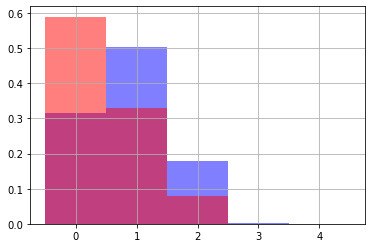

In [53]:
# print check
_ = (
    pd_TRAPS_df[vircles].qorder_flag.hist(bins=np.arange(-0.5, 5.5, 1), log=False, density=True, color='blue', alpha=0.5), 
    pd_TRAPS_df[vircles].qorder_flag_NBV.hist(bins=np.arange(-0.5, 5.5, 1), log=False, density=True, color='red', alpha=0.5)
)

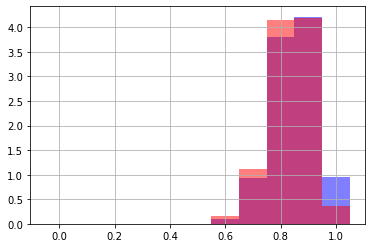

In [54]:
# print check
_ = (
    pd_TRAPS_df[vircles].pattern_agreement.hist(bins=np.arange(-0.05, 1.15, 0.1), log=False, density=True, color='blue', alpha=0.5), 
    pd_TRAPS_df[vircles].pattern_agreement_NBV.hist(bins=np.arange(-0.05, 1.15, 0.1), log=False, density=True, color='red', alpha=0.5)
)

# Export yearly pickle files

Since these files constitute the final TRAPs dataset for publication, we improve the metadata.

In [55]:
metadata = 'TRansient Attracting Profiles (TRAPs, Serra et al. (2020) published at https://doi.org/10.1038/s41467-020-16281-x)'
metadata += ' have been computed with code by Mattia Serra (https://github.com/MattiaSerra/TRAPs) and post-processed with code by'
metadata += ' Luca Kunz (https://github.com/kunzluca/trapsgpgp) using daily snapshots of near-surface geostrophic + Ekman currents'
metadata += ' from the product Global Total Surface and 15m Current (COPERNICUS-GLOBCURRENT) from Altimetric Geostrophic Current and'
metadata += ' Modeled Ekman Current Reprocessing that is provided by the E.U. Copernicus Marine Service (https://doi.org/10.48670/moi-00050).'
metadata += ' This work is a contribution to the project L3 (Meso- to submesoscale turbulence in the ocean) of the Collaborative Research Centre'
metadata += ' TRR 181 Energy Transfer in Atmosphere and Ocean funded by the German Research Foundation (DFG) and has been conducted in collaboration with The Ocean Cleanup.'
metadata += ' This dataset is licensed under the Creative Commons Attribution 4.0 International License (CC BY 4.0). © 2024 Luca Kunz.'
metadata += ' When using the dataset, please cite Kunz et al. (2024): "Transient Attracting Profiles in the Great Pacific Garbage Patch" and'
metadata += ' provide a link to the original dataset and related publications.'

metadata

'TRansient Attracting Profiles (TRAPs, Serra et al. (2020) published at https://doi.org/10.1038/s41467-020-16281-x) have been computed with code by Mattia Serra (https://github.com/MattiaSerra/TRAPs) and post-processed with code by Luca Kunz (https://github.com/kunzluca/trapsgpgp) using daily snapshots of near-surface geostrophic + Ekman currents from the product Global Total Surface and 15m Current (COPERNICUS-GLOBCURRENT) from Altimetric Geostrophic Current and Modeled Ekman Current Reprocessing that is provided by the E.U. Copernicus Marine Service (https://doi.org/10.48670/moi-00050). This work is a contribution to the project L3 (Meso- to submesoscale turbulence in the ocean) of the Collaborative Research Centre TRR 181 Energy Transfer in Atmosphere and Ocean funded by the German Research Foundation (DFG) and has been conducted in collaboration with The Ocean Cleanup. This dataset is licensed under the Creative Commons Attribution 4.0 International License (CC BY 4.0). © 2024 Luca

In [56]:
# create the objects
TRAPS_data = TRAPSdata(vel_product_short, metadata, pd_TRAPS_df)

In [57]:
# save the object as .pkl file
start_timer = time.perf_counter()

# construct the export file name
pkl_TRAPS_exportname = vel_product_short + epsilon_string + '_TRAPS_GPGP_' + year + '.pkl'

# save the object as .pkl file
save_object(TRAPS_data, pkl_exportpath + pkl_TRAPS_exportname)


stop_timer = time.perf_counter()
print('saved ' + pkl_TRAPS_exportname + f' in: {stop_timer - start_timer:0.1f} seconds')

saved MULTIOBS_24HI_e025_TRAPS_GPGP_2000.pkl in: 9.6 seconds


## End sound

In [58]:
# measure the computation time for the entire script
stop_script_timer = time.perf_counter()
print(f'overall computation time: {stop_script_timer - start_script_timer:0.3f} seconds')

overall computation time: 460.667 seconds


In [59]:
#https://gist.github.com/tamsanh/a658c1b29b8cba7d782a8b3aed685a24

framerate = 4410
play_time_seconds = 1

t = np.linspace(0, play_time_seconds, framerate*play_time_seconds)
# G-Dur
#audio_data = np.sin(2*np.pi*391*t) + np.sin(2*np.pi*493*t) + np.sin(2*np.pi*587*t)
# D-Dur
audio_data = np.sin(2*np.pi*293*t) + np.sin(2*np.pi*369*t) + np.sin(2*np.pi*440*t)
Audio(audio_data, rate=framerate, autoplay=True)